# Setup

Several factors are considered when teams draft prospects to the NBA, chief among them college statistics, personality, and the combine. Of the measurements taken at the combine, the max vertical jump is of particular interest to fans (and seemingly, to team scouts as well) as a strong predictor of a player's overall athletic ability and, thus, of a player's potential to score points. There are several notable examples of high-scoring players who seem to owe at least part of their success to their jumping ability such as Lebron James, Russell Westbook, and Giannis.

In this project, we will use causal machine learning tools from class to evaluate whether max vertical jump has a meaningful effect on a player's ability to score points. We used the NBA API to acquire combine statistics as well as scoring statistics about every active NBA player for our analysis. 

We placed a constraint that the players must be playing in the league currently, i.e. not retired, because (i) the NBA start recording combine measurements in 2000, eliminating players such as Michael Jordon from the analysis, and (ii) different eras feature different playstyles, and it is quite possible that the playstyle of the modern NBA rewards jumping high less than previous playstyles did. We want to evaluate whether a high vertical leads to success in the modern NBA. Moreover, we only include players who have played at least 82 games, which is equivalent to one season's worth of games.

Given a player, our treatment is whether or not they can jump at least 35 inches, our response is average career points per 36 minutes, and our covariates are height, weight, wingspan, and the results of an agility test, measuring speed. 

Below, we load the preprocessed data.

In [135]:
# Dependencies

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import matplotlib.lines as lines


In [75]:
data = pd.read_csv("./all_data")
# data = data.dropna()
data

,Unnamed: 0,PLAYER_ID,PTS,GP,BLK,REB,FT_PCT,PLAYER_NAME,FIRST_NAME,LAST_NAME,HEIGHT_WO_SHOES,WEIGHT,WINGSPAN,MAX_VERTICAL_LEAP,POSITION
0,0,2403,15.6,965,0.0,8.3,0.660,Nene,Nene,NaN,81.25,253.0,88.50,34.0,PF
1,1,203112,11.0,337,0.0,7.9,0.759,Quincy Acy,Quincy,Acy,78.50,223.8,86.75,37.0,PF
2,2,203500,12.8,588,0.0,10.3,0.548,Steven Adams,Steven,Adams,82.75,254.5,88.50,33.0,C
3,3,1628389,16.3,287,0.0,10.5,0.738,Edrice Adebayo,Edrice,Adebayo,80.75,242.6,86.75,38.5,PF-C
4,4,202399,11.9,153,0.0,11.0,0.628,Jeff Adrien,Jeff,Adrien,77.25,236.2,86.00,31.5,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,527,201156,18.0,720,0.0,3.1,0.836,Nick Young,Nick,Young,77.00,206.0,84.00,40.5,SG-SF
528,528,201970,13.0,249,0.0,5.2,0.742,Sam Young,Sam,Young,77.25,222.8,82.75,33.0,SF-SG
529,529,203923,9.7,95,0.0,4.3,0.563,James Young,James,Young,77.25,213.3,84.00,35.5,SG
530,530,203092,14.3,414,0.0,9.0,0.764,Tyler Zeller,Tyler,Zeller,83.25,247.4,84.00,34.0,PF-C


Mean free throw percentage to the left of the red line: 0.685
Mean free throw percentage to the right of the red line: 0.753


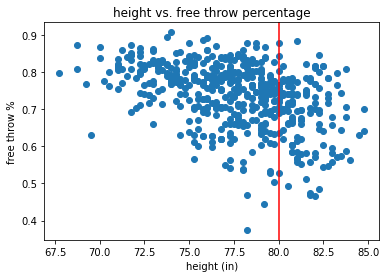

In [132]:
data["A"] = [1 if h >80 else 0 for h in data.HEIGHT_WO_SHOES]
print("Mean free throw percentage to the left of the red line:", round(np.mean(data[data.A == 1].FT_PCT), 3))
print("Mean free throw percentage to the right of the red line:",round(np.mean(data[data.A == 0].FT_PCT), 3))
plt.scatter(data.HEIGHT_WO_SHOES, data.FT_PCT)
plt.ylabel("free throw %")
plt.xlabel("height (in)")
plt.title("height vs. free throw percentage")
plt.axvline(x = 80, color = 'r', linestyle = '-')
plt.show()
# data.keys()

We separate response, treatment, and covariates for the double machine learning technique we will use. 

In [97]:
# Clean data again
data = data[[
#     'PTS',
#     'GP',
#     'BLK',
#     'REB',
    'WEIGHT',
    'WINGSPAN', 
    'MAX_VERTICAL_LEAP', 
    'POSITION', 
    'FT_PCT',
    'HEIGHT_WO_SHOES',
    'A'
]]
data = data.dropna()

# Response 
y = np.array(data.FT_PCT)

# Treatment 
heights = np.array(data.HEIGHT_WO_SHOES)
A = np.array([1 if h > 80 else 0 for h in heights])
data["A"] = A

# Covariates
label_encoder = LabelEncoder()
data["POSITION"] = label_encoder.fit_transform(np.array(data["POSITION"], dtype=str))

X_Q = data[[
#     'PTS',
#     'GP',
#     'BLK',
#     'REB',
    'WEIGHT',
    'WINGSPAN', 
    'MAX_VERTICAL_LEAP', 
    'POSITION', 
    'A'
]]
X_g = data[[ 
#     'PTS', 
#     'GP', 
#     'BLK', 
#     'REB', 
    'WEIGHT',
    'WINGSPAN', 
    'MAX_VERTICAL_LEAP', 
    'POSITION'
]]


,WEIGHT,WINGSPAN,MAX_VERTICAL_LEAP,POSITION,FT_PCT,HEIGHT_WO_SHOES,A
0,253.0,88.50,34.0,8,0.660,81.25,1
1,223.8,86.75,37.0,8,0.759,78.50,0
2,254.5,88.50,33.0,0,0.548,82.75,1
3,242.6,86.75,38.5,9,0.738,80.75,1
4,236.2,86.00,31.5,8,0.628,77.25,0
...,...,...,...,...,...,...,...
527,206.0,84.00,40.5,7,0.836,77.00,0
528,222.8,82.75,33.0,4,0.742,77.25,0
529,213.3,84.00,35.5,5,0.563,77.25,0
530,247.4,84.00,34.0,9,0.764,83.25,1


Below, we implement the augmented inverse probability of treatment weighted (AIPTW) estimator as described in the notes. We perform 5-fold cross-fitting to avoid paying the price of reusing data to train $g$, $Q$ as well as to compute the estimator $\tau$. 

In [86]:
def aiptw(Q, g, A_name, x_names, X_Q, X_g, A, y):
    X_Q_all_treatment = X_Q.copy()
    X_Q_all_treatment[A_name] = 1
    
    X_Q_no_treatment = X_Q.copy()
    X_Q_no_treatment[A_name] = 0
    
    Q_1_x = Q.predict(X_Q_all_treatment)
    Q_0_x = Q.predict(X_Q_no_treatment)
    
    
    g_x = g.predict_proba(X_g)[:,1]
    
    summands = Q_1_x - Q_0_x + A*(y-Q_1_x)/g_x - (1-A)*(y-Q_0_x)/(1-g_x)
    
    return np.mean(summands), np.var(summands)

In [136]:
def fold(train_index, test_index, A_name, x_names, X_Q, X_g, A, y):
    Q = GradientBoostingRegressor(n_estimators=10, learning_rate=0.2, max_depth=3, random_state=0, loss='ls')
    Q.fit(X_Q.iloc[train_index,:], y[train_index])
    
    y_pred = Q.predict(X_Q.iloc[test_index,:])
    Q_metrics = mean_squared_error(y[test_index], y_pred)

    
    g = LogisticRegressionCV(random_state=0)
    g.fit(X_g.iloc[train_index,:], A[train_index])
    
    A_pred = g.predict(X_g.iloc[test_index,:])
    g_metrics = np.array(confusion_matrix(A[test_index], A_pred))
    
    mean, var = aiptw(
        Q, g, A_name, 
        x_names, 
        X_Q.iloc[test_index,:], X_g.iloc[test_index,:], A[test_index], y[test_index])
    return mean, var, g_metrics, Q_metrics

We now apply the procedure to our data and record the estimated average treatment effect, the standard error, and the accuracy of $g$. 

In [137]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
mean = []
var = []
g_metrics = []
Q_metrics = []
for train_index, test_index in kf.split(A):
    mean_temp, var_temp, g_metrics_temp, Q_metrics_temp = fold(
        train_index, test_index, "A", 
        [ 
#     'PTS', 
#     'GP', 
#     'BLK', 
#     'REB', 
    'WEIGHT',
    'WINGSPAN', 
    'MAX_VERTICAL_LEAP', 
    'POSITION'
],
        X_Q, X_g, A, y
    )
    mean.append(mean_temp)
    var.append(var_temp)
    g_metrics.append(g_metrics_temp)
    Q_metrics.append(Q_metrics_temp)

In [143]:
print("ATE estimate is", np.round(np.mean(mean), 3))
print("Standard error is", np.round(np.sqrt(np.mean(var)), 3))
print("Variance is", np.round(np.mean(var), 3))

def get_accuracy(metrics):
    return (metrics[0,0] + metrics[1,1])/(metrics[0,0] + metrics[0,1] + metrics[1,0] + metrics[1,1])
accuracies = []
for metrics in g_metrics:
    accuracies.append(get_accuracy(metrics))
print(accuracies)

model_metrics = {
    "MSE of Q": Q_metrics, 
    "Accuracy of g": accuracies
}
model_metrics= pd.DataFrame(model_metrics)

all_metrics = {
    "tau": np.round(mean, 3),
    "var": np.round(var, 3)
}
all_metrics = pd.DataFrame(all_metrics)
all_metrics
model_metrics

np.mean(accuracies)

ATE estimate is -0.039
Standard error is 0.532
Variance is 0.283
[0.8878504672897196, 0.8490566037735849, 0.8301886792452831, 0.8584905660377359, 0.8207547169811321]


0.8492682066654911

We obtain a small point estimate of $\hat{\tau} = 0.417$ with a relatively large standard error of 8.548 across all folds. At first glance, these results suggest that a causal relationship does not exist from vertical to points. The propensity score estimate has a respectable accuracy of 70%. 

In [95]:
# Sensitivity analysis prep

Q = GradientBoostingRegressor(n_estimators=50, learning_rate=0.2, max_depth=3, random_state=0, loss='ls')
Q.fit(X_Q, y)

    
g = LogisticRegressionCV(random_state=0)
g.fit(X_g, A)

X_Q_all_treatment = X_Q.copy()
X_Q_all_treatment["A"] = 1

X_Q_no_treatment = X_Q.copy()
X_Q_no_treatment["A"] = 0

Q_1_x = Q.predict(X_Q_all_treatment)
Q_0_x = Q.predict(X_Q_no_treatment)

g_x = g.predict_proba(X_g)[:,1]

sensitivity_info = pd.DataFrame({
    "g": g_x,
    "Q": Q_1_x - Q_0_x, 
    "t": A,
    "y": y
})

In [96]:
sensitivity_info.to_csv("./sensitivity_info")
sensitivity_info

,g,Q,t,y
0,0.875704,-0.013891,1,0.660
1,0.498828,-0.001880,0,0.759
2,0.959982,-0.013891,1,0.548
3,0.487185,-0.000658,1,0.738
4,0.655195,-0.000658,0,0.628
...,...,...,...,...
526,0.106582,-0.001880,0,0.836
527,0.045301,-0.001880,0,0.742
528,0.302529,-0.001880,0,0.563
529,0.316778,-0.000658,1,0.764


In [148]:
for key in list(X_g.keys()):
    # Sensitivity analysis prep
    X_g_temp = X_g.drop([key], axis=1)
    X_Q_temp = X_Q.drop([key], axis=1)

    Q = GradientBoostingRegressor(n_estimators=50, learning_rate=0.2, max_depth=3, random_state=0, loss='ls')
    Q.fit(X_Q_temp, y)


    g = LogisticRegressionCV(random_state=0)
    g.fit(X_g_temp, A)

    X_Q_all_treatment = X_Q_temp.copy()
    X_Q_all_treatment["A"] = 1

    X_Q_no_treatment = X_Q_temp.copy()
    X_Q_no_treatment["A"] = 0

    Q_1_x = Q.predict(X_Q_all_treatment)
    Q_0_x = Q.predict(X_Q_no_treatment)

    g_x = g.predict_proba(X_g_temp)[:,1]

    sensitivity_info = pd.DataFrame({
        "g": g_x,
        "Q": Q_1_x - Q_0_x, 
        "t": A,
        "y": y
    })
    sensitivity_info.to_csv("./covariates/" + str(key) + ".csv")
